In [1595]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import math
from datetime import datetime
import matplotlib.pyplot as plt

In [1561]:
# Dashboard
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
#pd.options.display.max_rows = 4000
sns.set(style="white")
review_rate=0.5    # Assumed share of bookings that were followed up by a user review

In [1562]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [1563]:
# Import reviews.csv and convert date to datetime
data_rev = pd.read_csv("data/2020-02-18/reviews.csv")
data_rev.date = data_rev.date.astype('datetime64[D]')
print(data_rev.shape)
data_rev.head(3)

(543302, 2)


,listing_id,date
0,3176,2009-06-20
1,3176,2010-11-07
2,3176,2010-11-24


# Feature Engineering

The structure of the following sections is set with the aim to derive an estimate for the actual occupancy rate of listings (please see assumptions in notebook 1 | Clean for further notes):
- It is assumed that features at scraping date of "data" will determine occupancy rate for listings the month after (taking into consideration an assumed average lead time of two weeks for a booking)
- Reviews serve as proxy for bookings and will generally be written 1-14 days after finishing a trip
- Additional features are calculated in order to measure changes in price and other features compared to the month before "data"
- Listings that were inactive in any of the considered months (-1 month before data until 2 months after) are removed

## General Features

**Change column content**

In [1564]:
# Reduce cancellation_policy to 4 classes
data.cancellation_policy.replace(["strict_14_with_grace_period", "super_strict_60", "super_strict_30"], ["strict", "super_strict", "super_strict"], inplace=True)

In [1565]:
# Reduce property_type to 6 classes, as per Airbnb classification (see listing creation in pdf)
data.property_type.replace(["Condominium", "Loft", "Vacation home"], "Apartment", inplace=True)
data.property_type.replace(["Aparthotel", "Hostel", "Hotel", "Resort", "Serviced apartment"], "Boutique hotel", inplace=True)
data.property_type.replace(["Casa particular (Cuba)", "Farm stay", "Nature lodge", "Pension (South Korea)"], "Bed and breakfast", inplace=True)
data.property_type.replace(["Bungalow", "Cabin", "Chalet", "Cottage", "Dome house", "Earth house", "Houseboat", "Hut", "Lighthouse", "Tiny house", "Townhouse", "Villa"], "House", inplace=True)
data.property_type.replace(["Guesthouse", "Guest suite"], "Secondary unit", inplace=True)
data.property_type.replace(["Barn", "Boat", "Bus", "Camper/RV", "Campsite", "Castle", "Cave", "Igloo", "Island", "Plane", "Tent", "Tipi", "Train", "Treehouse", "Windmill", "Yurt"], "Unique space", inplace=True)


In [1566]:
# Drop all listings that are not in the above 6 classes
data = data[data.property_type.isin(["Apartment", "Boutique hotel", "Bed and breakfast", "House", "Secondary unit", "Unique space"])]

In [1567]:
# Fill all columns with "0" of "monthly_price" and "weekly_price" with 7x/30x "price"
data["monthly_price"] = np.where(data.monthly_price==0, data.price*30, data.monthly_price)
data["weekly_price"] = np.where(data.weekly_price==0, data.price*7, data.weekly_price)


**Convert binary features to 1/0**

In [1568]:
# Convert t/f to 1/0 for various features
data.host_is_superhost.replace(["t", "f"], [1, 0], inplace=True)
data.host_identity_verified.replace(["t", "f"], [1, 0], inplace=True)
data.is_location_exact.replace(["t", "f"], [1, 0], inplace=True)
data.instant_bookable.replace(["t", "f"], [1, 0], inplace=True)

In [1569]:
# Change availability_365 to 1/0
data.availability_365 = np.where(data.availability_365!=0, 1, 0)

In [1570]:
# Create 1/0 for text descriptions
#data["description_exist"] = [0 for i in range(len(data.index))]
data["description_exist"] = np.where(data.description!="", 1, 0)
data["house_rules_exist"] = np.where(data.house_rules!="", 1, 0)
data["interaction_exist"] = np.where(data.interaction!="", 1, 0)
data["neighborhood_overview_exist"] = np.where(data.neighborhood_overview!="", 1, 0)
data["notes_exist"] = np.where(data.notes!="", 1, 0)
data["space_exist"] = np.where(data.space!="", 1, 0)
data["summary_exist"] = np.where(data.summary!="", 1, 0)
data["transit_exist"] = np.where(data.transit!="", 1, 0)

**Create numerical features**

In [1571]:
# Calculate "price_calc" for one person from "price", "guests_included", "extra_people" and remove listings where "price_calc" ends up being <= 5
data["price_calc"] = data.price - 0.5*data.extra_people*(data.guests_included-1)
data = data[data.price_calc > 5]

In [1572]:
# Calculate "price_extra_people" (price) for additional persons from "price", "guests_included", "extra_people" and "accommodates"
data["price_extra_people"] = (data.extra_people*(data.accommodates-data.guests_included)+(0.5*data.extra_people*(data.guests_included-1)))/(data.accommodates-1)
data.price_extra_people.fillna(0, inplace=True)

In [1573]:
# Calculate existance of "price_extra_fees" from "security_deposit" and "cleaning_fee"
data["price_extra_fees"] = 0 + data.security_deposit + data.cleaning_fee

In [1574]:
# Calculate "descr_detail" as measure for how well the listing is described
data["descr_detail"] = 0 + data.description_exist + data.house_rules_exist + data.interaction_exist + data.neighborhood_overview_exist + data.notes_exist + data.space_exist + data.summary_exist + data.transit_exist

In [1575]:
# Calculate "accommodates_per_room" as feature to de-correlate "accommodates" and "bedrooms"
data["accommodates_per_room"] = data.accommodates/data.bedrooms

In [1576]:
# Calculate "accommodates_per_bed" as feature to de-correlate "accommodates" and "beds" and "bedrooms"
data["accommodates_per_bed"] = data.accommodates/data.beds

In [1577]:
# Calculate "wk_mth_discount" from "monthly_price" and "weekly_price" with "price"
data["wk_mth_discount"] = ((data.price*30-data.monthly_price)/(data.price*30) + (data.price*7-data.weekly_price)/(data.price*7)) / 2

**Create categorical features**

In [1578]:
# Categorize listings by "state" (basic, moderate, luxurious)

In [1579]:
# Create "text_len" as word count from text-based (.split().count)
data["description_len"] = [len(i.split()) for i in data.description]
data["house_rules_len"] = [len(i.split()) for i in data.house_rules]
data["interaction_len"] = [len(i.split()) for i in data.interaction]
data["neighborhood_overview_len"] = [len(i.split()) for i in data.neighborhood_overview]
data["notes_len"] = [len(i.split()) for i in data.notes]
data["space_len"] = [len(i.split()) for i in data.space]
data["summary_len"] = [len(i.split()) for i in data.summary]
data["transit_len"] = [len(i.split()) for i in data.transit]
data["text_len"] = (data.description_len/data.description_len.max() + data.house_rules_len/data.house_rules_len.max() +
                    data.interaction_len/data.interaction_len.max() + data.neighborhood_overview_len/data.neighborhood_overview_len.max() +
                    data.notes_len/data.notes_len.max() + data.space_len/data.space_len.max() + data.summary_len/data.summary_len.max() +
                    data.transit_len/data.transit_len.max()) / 8
data.text_len = data.text_len/data.text_len.max()

**Convert text columns into meaningful information**

In [1580]:
data.description.sample(5)

id
39391645    While I'm out of town I'm renting my cozy apar...
28943438    *** We are looking for a family or a couple to...
34362971    Sehr helles und ruhiges Einzimmerwohnung für 1...
39189315    Nice flat in center Berlin (Neukölln). Direct ...
11006340    We are away travelling and would like to suble...
Name: description, dtype: object

**Create log/sqrt from existing features**

Now we will replace certain features, which have relatively high skew (see 2_Clean), with their log

In [1581]:
# Create log "bathrooms_log" for numerical feature "bathrooms"
data["bathrooms_log"] = [math.log(el) for el in data["bathrooms"]]

In [1582]:
# Create sqrt "minimum_nights_sqrt" for numerical feature "minimum_nights"
data["minimum_nights_log"] = [math.sqrt(el) for el in data["minimum_nights"]]

In [1583]:
# Create log "price_extra_fees_sqrt" for numerical feature "price_extra_fees"
data["price_extra_fees_sqrt"] = [math.sqrt(el) for el in data["price_extra_fees"]]

In [1584]:
# Create log "price_log" for numerical feature "price_calc"
data["price_log"] = [math.log(el) for el in data["price_calc"]]

In [1585]:
# Create sqrt "review_scores_rating_sqrt" for numerical feature "review_scores_rating"
review_max = data.review_scores_rating.max()
data["review_scores_rating_sqrt"] = [math.sqrt(review_max-el) for el in data.review_scores_rating]
review_log_max = data.review_scores_rating_sqrt.max()
data["review_scores_rating_sqrt"] = [(review_log_max-el) for el in data.review_scores_rating_sqrt]
#data["review_scores_rating_sqrt"].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [1586]:
# Create log "text_len_sqrt" for numerical feature "text_len"
data["text_len_sqrt"] = [math.sqrt(el) for el in data["text_len"]]

**Opt.: Save of dataset***

In [1587]:
# Reindex and save cleaned and engineered dataset - ONLY IF NEEDED!
data = data.reindex(sorted(data.columns, reverse=False), axis=1)
data.to_pickle("saves/data_engineered_2019-12.pkl")

In [1588]:
data.shape

(23519, 81)

## Occupancy

Calculation of **occupancy rate** is inspired by the **San Francisco model**, which is also applied by [Inside AirBnB](http://insideairbnb.com/about.html):

- (**A**) Determine the **average length of stay for Berlin**
- (**B**) Calculate **reviews relevant for considered timeframe (Feb 1-29 2020)**
- (**C**) Determine **active months in timeframe** from price (not relevant if only 1 month)
- (**D**) Estimate **# of bookings in considered timeframe (End Jan-end Feb 2020)** using (**B**)
- (**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/months x 365)

Read more about the core idea behind the calculations of the model [here](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf). Assumptions were adapted for the purpose of this analysis, mainly due to the core idea of considering only the two most recent years.

(**A**) Determine the **average length of stay for Berlin** (assumed 3 days in most cities)

For the purpose of this model, around **3 nights** are assumed as average length of stay in Berlin and used as basis for calculation, unless a higher minimum length is specified
- Back in 2016, [4.6](https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf) has been reported as the average length of stay
- Inside AirBnB uses 3 nights for cities where no current data is available, but uses [6.3 nights](http://insideairbnb.com/berlin/#) for its Berlin visualization

In [1497]:
# Add column to main dataframe for avg length of stay, being either a) 5 nights or b) minimum_nights if higher than 5 or c) avg of min and max if max is 5 or lower
avg_nights = []
for idx in data.index:
    if data.maximum_nights[idx] <=5:
        avg_nights.append((data.maximum_nights[idx]+data.minimum_nights[idx])/2)
    elif data.minimum_nights[idx] >3:
        avg_nights.append(data.minimum_nights[idx])
    else:
        avg_nights.append(3)
data["avg_nights"] = avg_nights

(**B**) Calculate **reviews in last two years**

In [1498]:
# Create target dataframe
data_rev_count = data_rev[(data_rev.date > "2020-01-31") & (data_rev.date < "2020-03-01")]                          # Remove all reviews older than April 2018
data_rev_count = pd.DataFrame(data_rev_count.listing_id.value_counts())          # Count reviews per listing and save as table
data_rev_count.rename(columns={"listing_id": "reviews_feb20"}, inplace=True)     # Change column name
data = pd.merge(data, data_rev_count, how="left", left_index=True, right_index=True)    # Add column to main dataset
data.reviews_feb20.fillna(0, inplace=True)

(**C**) Determine **active months and relevant months** from price

In [1499]:
# Count the months where listings were online with a price (not relevant if 1 mth)
#data["active_months"] = data_ts.count(axis=1)
data["active_months"] = 1
relevant_mths = 1

(**D**) Estimate **# of bookings in last two years** by dividing (**B**) through a assumed 50% review rate (i.e. one review corresponds to two bookings)

In [1500]:
# Calculate bookings estimate and replace NaN with 0
data["bookings_est"] = data.reviews_feb20 / review_rate
data.bookings_est.fillna(0, inplace=True)

(**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/23 x 365)

In [1501]:
# Calculate occupancy rate
data["occupancy_rate"] = data.bookings_est * data.avg_nights / (data.active_months/relevant_mths*365)

In [1502]:
# Capping occupancy at 100%
occupancy_temp = []
for rate in data.occupancy_rate:
    if rate < 1:
        occupancy_temp.append(rate)
    else:
        occupancy_temp.append(1)
data.occupancy_rate = occupancy_temp

In [1503]:
# Split occupancy into 3 classes (TARGET)
occupancy_class = []
for rate in data.occupancy_rate:
    if rate < 0.25:
        occupancy_class.append(0)
    elif rate < 0.75:
        occupancy_class.append(1)
    else:
        occupancy_class.append(2)
data["occupancy_class"] = occupancy_class

## Seasonality

In [1504]:
# Import listings and create time series dataframe with prices for the time period 04/2018-03/2020 (2 years)

# Save "price" column of data (01/2020) as "data_ts"
data_ts = pd.DataFrame(data.price.copy())

# Rename "price" column to reflect the date "2020-01"
data_ts.rename(columns={"price": "2020-01"}, inplace=True)

# Import other files from 2 year period and add price column (renamed to reflect the date) to "data_ts"
all_files = glob.glob(os.path.join("data/timeseries", "*.csv.gz"))         # save paths of files as list
for f in all_files:                                                        # loop through all paths
    df_temp = pd.read_csv(f, sep=',')                                      # import each file from path and save as temporary dataframe
    df_temp.drop(df_temp.columns.difference(['id','price']), 1, inplace=True)        # keep only columns 'id' and 'price' in temporary dataframe
    df_temp.price = [float(i.strip("$").replace(",","")) for i in df_temp.price]        # convert 'price' into float
    data_ts = pd.merge(data_ts, df_temp, how="left", left_on='id', right_on='id')        # add 'price' from temporary dataframe onto full 'data_ts'
    f_date = f.split('/')[-1].split('_')[0]                                # temporarily save date from file path
    data_ts.rename(columns={"price": f_date}, inplace=True)                # change new 'price' column to reflect the date
    
# Set id as index again and sort columns (newest date to left)
data_ts.set_index('id', inplace=True)
data_ts = data_ts.reindex(sorted(data_ts.columns, reverse=True), axis=1)

# Print new dataframe and its shape
print(data_ts.shape)
data_ts.head()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38,43,61,62,84,85,94) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  # can fill in the output value.


(23790, 24)


,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,60.0,60.0,60.0,NaN,60.0,60.0,60.0,60.0
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,NaN,NaN,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0,NaN,NaN,NaN
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0


**Remove listings with missing price values in considered timeframe**

In [1505]:
# Add a boolean column for whether the listing has had any NaN's in the considered timeframe
data_ts["NaNs"] = [True if any(row.isnull()) else False for idx,row in data_ts.iloc[:,:4].iterrows()]

In [1506]:
# Create a list with all indices that have missing values for price in the considered timeframe
col_rem = list(data_ts[data_ts.NaNs==True].index)

In [1507]:
# Remove listings that have missing values in considered timeframe from "data", "data_ts_rel_mths" and other datasets
data.drop(col_rem, inplace=True)
data_ts.drop(col_rem, inplace=True)

**Add column for price change to "data"**

In [1508]:
# Calculate price changes from month before "data" (in USD)
data_ts["price_chg_2020_01"] = data_ts["2020-01"] - data_ts["2019-12"]

In [1509]:
# Add price change column to "data"
data = pd.merge(data, data_ts.price_chg_2020_01, how="left", left_on='id', right_on='id')

**Fill empty values in data_ts to calculate weighted avg price and seasonal weight (2 yrs from Apr'18 - Mar'20)**

In [1510]:
# Get a weighted average for monthly price

# Calculate monthly average for columns in 'data_ts' and save as list
mth_avg = []
for col in data_ts.columns:
    mth_avg.append(data_ts[col].median())

# Save weighted monthly average as dictionary
mth = ["02_Feb", "01_Jan", "12_Dec", "11_Nov", "10_Oct", "09_Sep", "08_Aug", "07_Jul", "06_Jun", "05_May", "04_Apr", "03_Mar"]


mth_avg_weight = {}
for i in range(11):
    mth_avg_weight.update({mth[i]:(mth_avg[i]*0.7+mth_avg[i+12]*0.3)})
mth_avg_weight.update({mth[11]:mth_avg[11]*0.95})
#print(mth_avg_weight)

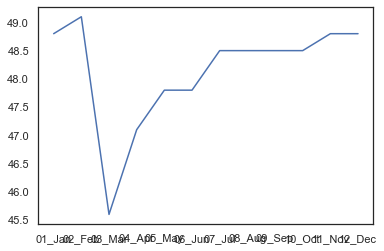

<Figure size 432x288 with 0 Axes>

In [1511]:
# Plot weighted average monthly price over year - IGNORE AS LOGICALLY REFLECTS MAR HIGHEST, APR LOWEST
lists = sorted(mth_avg_weight.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
plt.tight_layout()

In [1512]:
# Fill empty cells with values from next period
data_ts_filled = data_ts.copy()
data_ts_filled.fillna(axis=1, method='ffill')

#for i, col in enumerate(data_ts_filled.columns):
#    if i > 0:
#        data_ts_filled[col] = data_ts_filled[col].fillna(data_ts_filled[data_ts_filled.columns[i-1]])
data_ts_filled.head()


,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,False,0.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,False,0.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,False,0.0
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0,False,0.0
9991,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,False,0.0


In [1513]:
# Create column with calculated weighted average price
#weight = 0.4
#price_avg = []
#for 
data["price_avg"] = data_ts_filled.iloc[:,0]*0.5 + data_ts_filled.iloc[:,7]*0.25 + data_ts_filled.iloc[:,15]*0.15 + data_ts_filled.iloc[:,22]*0.10 

In [1514]:
# Create column with calculated price difference between current price and weighted average price
data["price_diff"] = data.price - data.price_avg

In [1515]:
# Create column with calculated price difference as percentage
data["price_diff_perc"] = data.price_diff / data.price

In [1516]:
# Output individual listings from data for review
#data[data.index==42343281]

In [1517]:
# Output individual listings from data_ts for review
data_ts[data_ts.index==36609709]

,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
36609709,150.0,350.0,72.0,77.0,77.0,77.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-5.0


In [1518]:
# Output individual listings from data_ts_filled for review
data_ts_filled[data_ts_filled.index==36609709]

,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,NaNs,price_chg_2020_01
id,,,,,,,,,,,,,,,,,,,,,,,,,,
36609709,150.0,350.0,72.0,77.0,77.0,77.0,77.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,False,-5.0


In [1519]:
# Check highest price vs avg differences
data[data.price_diff_perc>0.33].head()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode,description_exist,house_rules_exist,interaction_exist,neighborhood_overview_exist,notes_exist,space_exist,summary_exist,transit_exist,price_calc,price_extra_people,price_extra_fees,descr_detail,accommodates_per_room,accommodates_per_bed,wk_mth_discount,description_len,house_rules_len,interaction_len,neighborhood_overview_len,notes_len,space_len,summary_len,transit_len,text_len,bathrooms_log,minimum_nights_log,price_extra_fees_sqrt,price_log,review_scores_rating_sqrt,text_len_sqrt,avg_nights,reviews_feb20,active_months,bookings_est,occupancy_rate,occupancy_class,price_chg_2020_01,price_avg,price_diff,price_diff_perc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1564806,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",1,1.5,1.0,1.0,49,strict,0.0,"with 12-man communal shared bathroom, TV, WIFI...",23.0,1,0,0,- check out before 10:00 am. - no smoking in t...,0,There is always at least 1 member of staff on ...,1,52.51614,13.42485,14,1,4500.0,"6-Bed mixed dorm ,Shared Bathroom 3",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,150.0,Boutique hotel,91.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with 12-man communal shared bathroom, TV, WIFI...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,1050.0,zip_10179,1,1,1,1,1,1,1,1,150.0,23.0,0.0,8,6.0,6.0,0.000000,182,49,25,60,101,78,45,46,0.466155,0.405465,1.000000,0.000000,5.010635,5.944272,0.682756,3.0,1.0,1,2.0,0.016438,0,127.0,85.0,65.0,0.433333
1564917,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",1,1.5,1.0,1.0,49,strict,0.0,"with bathroom, TV, WIFI, bed linen, and storag...",27.0,1,0,0,- Check out before 10:00 a.m. - No smoking in ...,0,There is always at least 1 member of staff on ...,1,52.51767,13.42518,14,1,2970.0,"4-Bedroom mixed, Ensuite , TV No. 1",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,99.0,Boutique hotel,93.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with bathroom, TV, WIFI, bed linen, and storag...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,693.0,zip_10179,1,1,1,1,1,1,1,1,99.0,27.0,0.0,8,4.0,4.0,0.000000,180,96,25,60,101,78,42,46,0.499039,0.405465,1.000000,0.000000,4.595120,6.298521,0.706427,3.0,0.0,1,0.0,0.000000,0,66.0,66.0,33.0,0.333333
1565012,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",1,1.5,1.0,1.0,49,strict,0.0,"with en-suite bathroom, TV, WIFI, bed linen, a...",25.0,1,0,0,- check out before 10:00 am. - no smoking in t...,0,There is always at least 1 member of staff on ...,1,52.51756,13.42441,14,1,4500.0,"6-Bedroom mixed, Ensuite , TV No. 1",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,150.0,Boutique hotel,93.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with en-suite bathroom, TV, WIFI, bed linen, a...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,1050.0,zip_10179,1,1,1,1,1,1,1,1,150.0,25.0,0.0,8,6.0,6.0,0.000000,180,49,25,60,101,78,43,46,0.462891,0.405465,1.000000,0.00000

**Create columns to calculate difference from previous periods**

In [1593]:
data.head(20)

,accommodates,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bathrooms_log,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,descr_detail,description,description_exist,description_len,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,house_rules_exist,house_rules_len,instant_bookable,interaction,interaction_exist,interaction_len,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,minimum_nights_log,monthly_price,name,neighborhood_overview,neighborhood_overview_exist,neighborhood_overview_len,neighbourhood,notes,notes_exist,notes_len,price,price_calc,price_extra_fees,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating,review_scores_rating_sqrt,room_type,security_deposit,space,space_exist,space_len,summary,summary_exist,summary_len,text_len,text_len_sqrt,transit,transit_exist,transit_len,weekly_price,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,3,1.500000,3.00,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",1,1.0,0.000000,1.0,2.0,3,moderate,30.0,8,Great location! 30 of 75 sq meters. This wood...,1,164,28.0,1,1,1,"No parties No events No pets No smoking, not e...",1,36,0,Always available,1,2,0,52.53454,13.40256,1125,4,2.000000,1800.0,Berlin-Mitte Value! Quiet courtyard/very central,It is located in the former East Berlin area o...,1,62,Mitte,"This is my home, not a hotel. I rent out occas...",1,17,60.0,60.0,280.0,16.733201,28.000000,4.094345,Secondary unit,93.0,6.298521,Entire home/apt,250.0,A+++ location! This „Einliegerwohnung“ is an e...,1,159,Great location! 30 of 75 sq meters. This wood...,1,79,0.439903,0.663252,"Close to U-Bahn U8 and U2 (metro), Trams M12, ...",1,32,420.0,0.000000,zip_10119
3176,4,2.000000,4.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",1,1.0,0.000000,1.0,2.0,1,strict,100.0,8,This beautiful first floor apartment is situa...,1,175,20.0,2,1,0,"It’s a non smoking flat, which likes to be tre...",1,41,0,Feel free to ask any questions prior to bookin...,1,55,1,52.53500,13.41758,1125,62,7.874008,1900.0,Fabulous Flat in great Location,The neighbourhood is famous for its variety of...,1,78,Prenzlauer Berg,We welcome FAMILIES and cater especially for y...,1,109,90.0,80.0,400.0,20.000000,16.666667,4.382027,Apartment,93.0,6.298521,Entire home/apt,300.0,1st floor (68m2) apartment on Kollwitzplatz/ P...,1,177,This beautiful first floor apartment is situa...,1,35,0.579794,0.761442,"We are 5 min walk away from the tram M2, whic...",1,61,520.0,0.235450,zip_10405
3309,1,1.000000,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,""Pets live on this property"",Ca...",1,1.0,0.000000,1.0,1.0,1,strict,30.0,8,First of all: I prefer short-notice bookings. ...,1,181,18.0,1,0,0,House-Rules and Information ..............(deu...,1,165,0,I'm working as a freelancing photographer. My ...,1,179,1,52.49885,13.34906,35,7,2.645751,599.0,BerlinSpot Schöneberg near KaDeWe,"My flat is in the middle of West-Berlin, direc...",1,46,Schöneberg,The flat is a strictly non-smoking facility! A...,1,49,28.0,28.0,280.0,16.733201,0.000000,3.332205,Apartment,89.0,5.627647,Private room,250.0,"Your room is really big and has 26 sqm, is ver...",1,187,First of all: I prefer short-notice bookings. ...,1,69,0.736878,0.858416,The public transportation is excellent: Severa...,1,58,175.0,0.197024,zip_10777
6883,2,2.000000,2.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,1.0,0.000000,1.0,1.0,1,moderate,39.0,7,Stay in a stylish loft

In [1597]:
# Import data from month before data_clean
data_raw_2019_12 = str.encode(pd.read_csv("saves/data_engineered_2019-12.pkl"))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [1369]:
# Assign raw import to dataset (in order to always keep a freshly imported raw set) and set id as index
data_2019_12 = data_raw_2019_12.copy()
data_2019_12.set_index('id', inplace=True)

In [1375]:
# Keep only relevant listings in datasets from previous time periods
row_keep = list(data.index)
data_2019_12 = data_2019_12[data_2019_12.index.isin(row_keep)]

**Merge columns from previous periods to "data"**

In [1376]:
# Create "text_len" as word count from text-based (.split().count)

# Fill missing values with ""
data_2019_12.description.fillna("", inplace=True)
data_2019_12.interaction.fillna("", inplace=True)
data_2019_12.house_rules.fillna("", inplace=True)
data_2019_12.neighborhood_overview.fillna("", inplace=True)
data_2019_12.notes.fillna("", inplace=True)
data_2019_12.space.fillna("", inplace=True)
data_2019_12.summary.fillna("", inplace=True)
data_2019_12.transit.fillna("", inplace=True)

# Count length of text
data_2019_12["description_len"] = [len(i.split()) for i in data_2019_12.description]
data_2019_12["house_rules_len"] = [len(i.split()) for i in data_2019_12.house_rules]
data_2019_12["interaction_len"] = [len(i.split()) for i in data_2019_12.interaction]
data_2019_12["neighborhood_overview_len"] = [len(i.split()) for i in data_2019_12.neighborhood_overview]
data_2019_12["notes_len"] = [len(i.split()) for i in data_2019_12.notes]
data_2019_12["space_len"] = [len(i.split()) for i in data_2019_12.space]
data_2019_12["summary_len"] = [len(i.split()) for i in data_2019_12.summary]
data_2019_12["transit_len"] = [len(i.split()) for i in data_2019_12.transit]
# Normalization (0-1) is done further below when comparing text_len to "data"


In [1377]:
# Keep only relevant features in datasets from previous time periods (used further below for "calculating difference from previous periods")
data_2019_12 = data_2019_12[["accommodates", "bathrooms", "bedrooms", "beds",
                            "minimum_nights", "host_is_superhost",
                            "host_identity_verified", "instant_bookable",
                            "description_len", "house_rules_len", "interaction_len",
                            "neighborhood_overview_len", "notes_len", "space_len",
                            "summary_len", "transit_len"]]
data_2019_12 = data_2019_12.reindex(sorted(data_2019_12.columns, reverse=False),
                                    axis=1)

In [1378]:
# Rename columns
data_2019_12.rename(columns=lambda x: x+"_2019_12", inplace=True)

In [1379]:
# Add columns from previous dataset(s) to "data"
data = pd.merge(data, data_2019_12, how="left", left_on='id', right_on='id')

In [1417]:
# Column for numeric features
data["numeric_chg"] = (data.accommodates-data.accommodates_2019_12) + (data.bathrooms-data.bathrooms_2019_12) + (data.bedrooms-data.bedrooms_2019_12) + (data.beds-data.beds_2019_12)

In [1422]:
# Column for binary features
data.host_is_superhost_2019_12.replace(["t", "f"], [1, 0], inplace=True)
data.host_identity_verified_2019_12.replace(["t", "f"], [1, 0], inplace=True)
data.instant_bookable_2019_12.replace(["t", "f"], [1, 0], inplace=True)
data["binary_chg"] = (data.host_identity_verified-data.host_identity_verified_2019_12) + (data.host_is_superhost-data.host_is_superhost_2019_12) + (data.instant_bookable-data.instant_bookable_2019_12)

In [1423]:
# Column for minimum night feature
data["minimum_nights_chg"] = data.minimum_nights-data.minimum_nights_2019_12

In [1428]:
# Column for text features
data["text_len_2019_12"] = (data.description_len_2019_12/data.description_len.max() + data.house_rules_len_2019_12/data.house_rules_len.max() +
                    data.interaction_len_2019_12/data.interaction_len.max() + data.neighborhood_overview_len_2019_12/data.neighborhood_overview_len.max() +
                    data.notes_len_2019_12/data.notes_len.max() + data.space_len_2019_12/data.space_len.max() + data.summary_len_2019_12/data.summary_len.max() +
                    data.transit_len_2019_12/data.transit_len.max()) / 8
data.text_len_2019_12 = data.text_len_2019_12/data.text_len.max()    # Compare to "data" in order to keep lengths comparable
data["text_len_chg"] = data.text_len - data.text_len_2019_12

## Final Check, Cleaning and Export

In [1176]:
# Drop further columns
data.drop(["accommodates", "active_months_lt2yr", "amenities", "am_coffee_machine",
           "am_cooking_basics", "am_parking", "availability_365",
           "avg_nights", "bathrooms", "beds", "bookings_est", 
           "cleaning_fee", "descr_detail", "description", "description_exist", "description_len",
           "description_exist", "extra_people", "guests_included", "host_identity_verified",
           "house_rules", "house_rules_exist", "house_rules_len", "interaction", "interaction_exist", 
           "interaction_len", "is_location_exact", "minimum_nights",
           "monthly_price", "name", "neighborhood_overview", "neighborhood_overview_exist", 
           "neighborhood_overview_len", "notes", "notes_exist", "notes_len", "occupancy_rate",
           "price", "price_avg", "price_calc", "price_diff", "price_diff_perc", "price_extra_fees", 
           "review_scores_rating", "reviews_lt2yr", "security_deposit", 
           "space", "space_exist", "space_len", "summary", "summary_exist", "summary_len", "text_len",
           "transit", "transit_exist", "transit_len", "weekly_price"], inplace=True, axis=1)

| **DROPPED FEATURE** | **REASONING** |
| :----- | :----- |
| **am_coffee_machine** | high correlation (>0.3) with >5 other features |
| **am_parking** | high correlation (>0.3) with >5 other features |
| **availability_365** | high correlation (>0.3) with >5 other features |
| **descr_detail** | dropped in favour of **text_len** |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |


In [1177]:
# Review datatypes (data.info()) (post-engineering)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23623 entries, 3176 to 42361801
Data columns (total 34 columns):
am_balcony                        23623 non-null float64
am_breakfast                      23623 non-null float64
am_child_friendly                 23623 non-null float64
am_elevator                       23623 non-null float64
am_essentials                     23623 non-null float64
am_nature_and_views               23623 non-null float64
am_pets_allowed                   23623 non-null float64
am_private_entrance               23623 non-null float64
am_smoking_allowed                23623 non-null float64
am_tv                             23623 non-null float64
am_white_goods                    23623 non-null float64
bedrooms                          23623 non-null float64
calculated_host_listings_count    23623 non-null int64
cancellation_policy               23623 non-null object
host_is_superhost                 23623 non-null int64
instant_bookable                  2

In [1178]:
# Sort columns in dataset
data = data.reindex(sorted(data.columns, reverse=False), axis=1)

In [1179]:
# Display engineered dataset
print(data.shape)
data.head(3)

(23623, 34)


,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,bathrooms_log,bedrooms,calculated_host_listings_count,cancellation_policy,host_is_superhost,instant_bookable,latitude,longitude,maximum_nights,minimum_nights_log,neighbourhood,occupancy_class,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating_sqrt,room_type,text_len_sqrt,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,2.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,strict,0,0,52.53500,13.41758,1125,7.874008,Prenzlauer Berg,4,20.000000,16.666667,4.382027,Apartment,6.298521,Entire home/apt,0.772455,0.235450,zip_10405
3309,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,strict,0,0,52.49885,13.34906,35,2.645751,Schöneberg,1,16.733201,0.000000,3.332205,Apartment,5.627647,Private room,0.863107,0.197024,zip_10777
6883,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,moderate,0,0,52.51171,13.45477,90,1.732051,Friedrichshain,3,6.244998,0.000000,4.828314,Apartment,7.944272,Entire home/apt,0.630012,0.471181,zip_10243


**Export data_engineered**

In [1180]:
# Export dataset for further use in 4_Predictive Modeling
data.to_pickle("saves/data_engineered.pkl")

In [1181]:
# Alternative: Export with to_csv and save dtypes separately
#data.to_csv(r'saves/data_engineered.csv', index = True)
#data.dtypes.to_frame('types').to_csv('saves/types_engineered.csv')